# Task and Data Analysis

#### Overview of the Data

The dataset consists of product reviews from Amazon, segmented into features with annotated sentiment scores. Reviews include multiple aspects such as ease of use, picture quality, and additional functionalities, each tagged with a corresponding sentiment score. These annotations provide a rich basis for sentiment analysis but require precise parsing to effectively utilize the structured format in which they are presented.

#### System-Level Outline

##### Data Parsing and Pre-processing

Using a custom `read_file` function, the system initially parses the structured reviews from text files. This function handles the dataset's specific format, which includes initial metadata and reviewer comments split by a unique delimiter ('##'). This is crucial for separating feature tags from review content, facilitating subsequent analysis.

The `pre_process_review` function further refines this by extracting titles and adjusting reviews accordingly, ensuring that the context provided by review headers is not lost. Additionally, it preserves the integrity of the review flow, which is vital for understanding the nuances of each review.

##### Enhancing NLP with Custom Processing

To deepen the analysis, the `preserve_compound_phrases` function is employed. This function utilizes an NLP model to identify and preserve compound nouns and adjectives directly linked to nouns, which are often critical in understanding the specific features discussed. By preserving these compounds, the system maintains the granular detail necessary for precise feature extraction.

Following this, the `chunking_post_process` method reassembles the text from tokenized forms back into a structured format conducive to further analysis, ensuring that compound phrases are treated as single entities within the dataset.

##### Comprehensive Review Filtering

The `pre_processing_controller` function orchestrates the entire preprocessing pipeline. It transforms raw review texts into a tokenized format, applies compound preservation, and executes two levels of filtering: soft filtering (preserving basic structure and some stopwords) and hard filtering (removing all non-alphabetic characters and stopwords). This dual approach allows for flexibility in analysis, from high-level sentiment trends to detailed feature-specific sentiments.

##### Sentiment Analysis and Feature Extraction

Once preprocessed, the data is ripe for sentiment analysis. Leveraging the structured format of feature tags and sentiment scores, the system can map sentiments directly to product features, allowing for an aggregated sentiment score for each feature. This quantification is pivotal in determining which features are most appreciated or criticized by users.

##### Leveraging Data for Business Insights

The final step involves synthesizing the analyzed data into actionable business insights. By understanding which features correlate strongly with positive or negative sentiments, companies can prioritize product improvements or highlight successful aspects in marketing strategies.

In [20]:
import pandas as pd
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
Word2Vec_corpus = api.load('text8') 
Word2Vec_model = Word2Vec(Word2Vec_corpus) 
glove_model = api.load("glove-twitter-25") 
sentiment_intensity_analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /Users/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
files = ['Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt',
         'Data/Customer_review_data/Canon G3.txt',
         'Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
         'Data/Customer_review_data/Nikon coolpix 4300.txt',
         'Data/Customer_review_data/Nokia 6610.txt',
         'Data/CustomerReviews-3_domains/Computer.txt',
         'Data/CustomerReviews-3_domains/Router.txt',
         'Data/CustomerReviews-3_domains/Speaker.txt',
         'Data/Reviews-9-products/Canon PowerShot SD500.txt',
         'Data/Reviews-9-products/Canon S100.txt',
         'Data/Reviews-9-products/Diaper Champ.txt',
         'Data/Reviews-9-products/Hitachi router.txt',
         'Data/Reviews-9-products/ipod.txt',
         'Data/Reviews-9-products/Linksys Router.txt',
         'Data/Reviews-9-products/MicroMP3.txt',
         'Data/Reviews-9-products/Nokia 6600.txt',
         'Data/Reviews-9-products/norton.txt']

# Data Pre-Processing

### Data Ingestion and Initial Processing

The process starts with the ingestion of data files containing multiple reviews, which can vary in structure. This step is crucial for setting the stage for detailed analysis. The function `read_file` is used to open and read the contents of these files. Reviews are often separated by new lines and may begin with a distinctive line of asterisks, which indicates metadata or headers not part of the actual review content. These non-relevant lines are programmatically identified and omitted from processing to ensure only pertinent text is analyzed further.

The reviews within these files are then split using '##' as a delimiter. This segmentation is critical as it separates tags that contain embedded metadata or sentiment scores from the main content. Each segment of the review, along with its associated tags, is stored in a structured format within a pandas DataFrame, which facilitates ease of manipulation and detailed analysis in subsequent steps.

### Advanced Text Processing Techniques

Once the initial data ingestion is complete, the reviews undergo various text processing steps encapsulated within the `pre_process_review` function. This function is adept at managing different nuances of text, such as concatenating titles where necessary, and ensuring the textual integrity of reviews that span multiple lines is maintained.

### Preservation of Semantic Structures

To maintain the semantic integrity of phrases within the reviews, the `preserve_compound_phrases` function is employed. This function utilizes spaCy, an advanced NLP library, to parse the text and identify compound nouns and adjectival modifiers. These elements are crucial for understanding the context and sentiment related to specific product features. The identified compounds are then reconstructed with underscores replacing spaces, ensuring they are treated as single tokens in subsequent analysis stages. This preservation prevents the loss of semantic unity and is vital for the accurate interpretation of product features.

### Enhancement of Tokenization and Filtering

Following the preservation of semantic structures, the `pre_processing_controller` function orchestrates several layers of tokenization and filtering. The text is initially tokenized, which separates each word or phrase for individual analysis. This tokenization process feeds into a dual filtering system:

1. A 'Soft Filtered Review' captures tokens that either are part of the identified compound phrases or are standalone alphabetic words. This layer ensures that important phrases and words are retained without too much reduction of the text.
2. A 'Filtered Review' applies a more stringent filter that includes the removal of common stop words, focusing only on the more meaningful terms relevant to sentiment analysis. This selective filtering is crucial for reducing noise and enhancing the focus on significant textual elements.

These tokens are then reassembled into coherent strings, which form the basis for deeper linguistic analysis, such as lemmatization. The 'Soft Filtered Review' is transformed back into a string format while retaining the structural integrity of compound phrases. Lemmatization is performed on the 'Filtered Review' strings to reduce words to their base or dictionary form, which facilitates a more generalized but robust analysis of text data.

In [22]:
def read_file(file_path):
    
    tagged_reviews = []
    
    with open(file_path, 'r') as file:
        text = file.read()
        # Split the text into lines and remove any leading/trailing whitespace
        reviews = text.strip().split('\n')

        # Check if the file starts with a specific marker line of asterisks
        if reviews[0] == '*' * 77:
            # Skip the first 11 lines if the marker is present - This is a quirk to parse the data files
            reviews = reviews[11:]

        reviews = pre_process_review(reviews)
        
        for review in reviews:
            # Split each review on '##' to separate tags from the content
            parts = review.split('##')
            
            # If the split results in more than one part, process tags and content
            if len(parts) > 1:
                tags = parts[0].strip().split(',')
                content = parts[1].strip() 
            else:
                # If no '##' is found, set tags as empty and set content to the whole line
                tags = []
                content = parts
                
            # Append a dictionary of tags and review content to the list
            tagged_reviews.append({'Tags': tags, 'Review': content})

        df = pd.DataFrame(tagged_reviews)
        # Store the name of the file as an attribute of the DataFrame
        df.attrs['title'] = file_path.split('/')[-1]

        return df

In [23]:
# Pre-processing functions

def pre_process_review(reviews):
    processed_reviews = []
    title_switch = False  # Indicates whether next review should append a title
    title = ''

    for review in reviews:
        if review.startswith('[t]'):  # Checks for title marker
            title = review[3:]  # Stores the title
            title_switch = True
        elif title_switch:  # Appends title to the review if flag is true
            processed_reviews.append(review + title)
            title_switch = False
            title = ''
        else:
            processed_reviews.append(review)  # Adds review as is if no title is pending

    return processed_reviews



def preserve_compound_phrases(text):
    # Process the text with an NLP model
    doc = nlp(text)
    processed_tokens = []

    for token in doc:
        # Check for compounds or adjectives linked directly to nouns
        if token.dep_ in ('compound', 'amod') and token.head.pos_ == 'NOUN':
            compound_phrase = f"{token.text}_{token.head.text}"
            if compound_phrase not in processed_tokens:
                processed_tokens.append(compound_phrase)
        # Skip nouns that are already part of a compound to prevent duplicates
        elif token.pos_ == 'NOUN' and any(child.dep_ == 'compound' for child in token.children):
            continue
        # Include all other tokens normally
        else:
            processed_tokens.append(token.text)

    return processed_tokens




def chunking_post_process(text):
    # Split the text into individual words
    words = text.split()
    processed_words = []

    i = 0
    while i < len(words):
        # Check if the current word is part of a compound phrase
        if '_' in words[i]:
            # Append all parts of the compound phrase to the list
            while i < len(words) and '_' in words[i]:
                processed_words.append(words[i])
                i += 1
            continue  # Move to the next word after finishing the compound phrase
        # Append non-compound words directly to the list
        processed_words.append(words[i])
        i += 1

    # Return the processed words as a single string
    return ' '.join(processed_words)

In [24]:
def pre_processing_controller(df):
    
    # Convert lists to strings and applies compound phrase preservation
    df['Tokenised_Review'] = df['Review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    df['Tokenised_Review'] = df['Tokenised_Review'].apply(lambda review: preserve_compound_phrases(review))
    
    # Filters the reviews. Handling compound phrases, capitalisation and numbers 
    df['Soft_Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower())])
    
    # Convert lists of tokens back to strings and retains the compound phrases - soft means not to filter out stop words
    df['Soft_Filtered_Review_String'] = df['Soft_Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
    df['Soft_Filtered_Review_String'] = df['Soft_Filtered_Review_String'].apply(chunking_post_process)
    
    # Filters the reviews. Handling compound phrases, capitalisation, numbers and stop words 
    df['Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower() not in stop_words)])
    df['Filtered_Review_String'] = df['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
    
    # Lemmatise the filtered review strings
    df['Lemmatised_Review_String'] = df['Filtered_Review_String'].apply(lambda review_string: " ".join([token.lemma_ for token in nlp(review_string)]))
    df['Lemmatised_Tokenised_Filtered_Review'] = df['Filtered_Review_String'].apply(lambda review: word_tokenize(review))
    
    return df

# Product Feature Extraction

##### Part-of-Speech (POS) Noun Tagging

The first step in the feature extraction process is the identification of nouns from customer reviews. This is accomplished by the `POS_Noun_Tagging` function, which employs tokenization and POS tagging to sift through the textual data. Nouns are indicative of features, as they often name the components or aspects of a product that customers discuss. By focusing on nouns, the function narrows down the vast amount of information in reviews to specific elements likely relevant to consumer sentiments.

##### Concrete Noun Identification

Further refining the noun extraction, the `is_concrete_noun` function determines whether a noun describes tangible aspects of a product, such as an "object" or "device." This distinction is crucial because tangible feature mentions often directly relate to customer satisfaction and are actionable from a product improvement perspective. Using WordNet synsets and their hypernyms allows for an understanding of the word's concreteness in context, enhancing the relevance of the extracted features.

##### Similarity-Based Filtering

With the noun list refined to concrete nouns, the `similarity_filter` function applies vector space models like Word2Vec and GloVe to filter out words based on their semantic similarity. This step is vital to cluster similar features together, reducing redundancy and focusing on unique aspects mentioned across reviews. By setting a similarity threshold, the function ensures only significantly similar terms are grouped, maintaining a diverse yet focused feature set.

##### Further Similarity Filtering

The `further_similar_filter` function adds another layer of filtering by using GloVe's similarity scoring to eliminate closely related nouns, further condensing the feature list. This step is particularly useful in focusing on the most mentioned and hence potentially impactful features in customer reviews.

##### Building the Feature Dictionary and DataFrames

The `create_product_features_dict` function initializes a structured dictionary to map each product feature against its mentions and sentiment polarity. This dictionary is foundational for aggregating and analyzing sentiment data related to each feature. The `build_featured_df` function then constructs a DataFrame from the reviews, associating each with identified features and preparing the data for sentiment analysis.

##### Sentiment Analysis and Count Aggregation

The final analytical steps involve `feature_dict_count`, which tallies positive and negative mentions for each feature, providing a quantified sentiment outlook for each aspect of the product. This aggregation is pivotal for identifying strengths and weaknesses in the product as perceived by consumers.

##### Efficient Data Management

Lastly, the `df_filter` function restructures the DataFrame to optimize it for analysis, ensuring data is clean and well-organized for subsequent processing steps or visualization.


In [25]:
def feature_extraction(df):
    nouns = POS_Noun_Tagging(df)
    features = similarity_filter(nouns)
    feature_df = build_featured_df(df, features)
    return feature_df, features


def POS_Noun_Tagging(df):
    # Convert the string list to a regular list
    reviews = df['Lemmatised_Review_String'].tolist()
    features = []
    
    # Process each review to extract nouns
    for review in reviews:
        tokens = word_tokenize(review)  # Tokenize the text
        tagged = pos_tag(tokens)  # POS tagging
        # Collect nouns from tags
        features.extend(word.lower() for word, tag in tagged if tag.startswith('NN'))
    
    # Count and retrieve the 15 most common nouns
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(10)
    
    return common_features



def is_concrete_noun(word):
    # Define indicators for concrete nouns
    concrete_indicators = {'object', 'artifact', 'instrumentality', 'container', 'device'}
    # Retrieve synsets for the word as a noun
    synsets = wn.synsets(word, pos=wn.NOUN)
    
    # Check categories for each synset to determine if it's a concrete noun
    for synset in synsets:
        for hypernym in synset.closure(lambda s: s.hypernyms()):
            if concrete_indicators.intersection(hypernym.lemma_names()):
                return True
    return False

In [26]:
def similarity_filter(word_tuple_list):
    # Set a threshold for filtering similar words
    similarity_threshold = 0.25
    
    # Create a list of words from the tuples
    words = [word for word, _ in word_tuple_list]
    
    noun_list = []
    # Iterate over words to compute similarities
    for word in words:
        try:
            # Calculate similarity using Word2Vec
            w2v_similarity = Word2Vec_model.wv.similarity(words[0], word)
            # Calculate similarity using GloVe
            glove_similarity = glove_model.similarity(words[0], word)
            
            # Calculate average similarity
            avg_similarity = (w2v_similarity + glove_similarity) / 2
            
            # Append word to list if it meets the threshold
            if avg_similarity >= similarity_threshold:
                noun_list.append(word)
        except KeyError:
            # Skip the word if it's not found in the model's vocabulary
            continue

    items_to_remove = []
    
    for word in noun_list:
        glove_similar_words = dict(glove_model.most_similar(noun_list[0], topn=10))
        glove_similarity = glove_similar_words.get(word, 0) 
        if glove_similarity > 0:
            items_to_remove.append(word)
    
    filtered_nouns = [item for item in noun_list if item not in items_to_remove]
    
    return filtered_nouns


In [27]:
def build_featured_df(df, features):
    
    feature_df = pd.DataFrame()
    feature_list = features[1:]
    
    featured_items_list = []
    
    for idx, review in df.iterrows():
        tokenised_review = review['Filtered_Review']
        # Find the features present in the tokenised_review
        featured_items = [item for item in feature_list if item in tokenised_review]
            
        if featured_items:
            # Convert the review Series to a DataFrame with one row
            review_df = review.to_frame().transpose()
            
            # New: Append the found features as a string (or you can keep it as list)
            review_df['Featured_Items'] = [', '.join(featured_items)]  # As a single string of items
    
            review_df['Main_Index'] = idx
            
            # Append this review to the feature_df
            feature_df = pd.concat([review_df, feature_df], axis=0)
            
            # Additionally, append the found features to the featured_items_list
            featured_items_list.append(featured_items)

    return feature_df



def create_feature_table(df, features):

    df = df[['Main_Index', 'Featured_Items', 'Sentiment', 'Tags', 'Review', 'Tokenised_Review', 'Soft_Filtered_Review', 'Soft_Filtered_Review_String', 'Filtered_Review', 'Filtered_Review_String', 'Lemmatised_Review_String', 'Lemmatised_Tokenised_Filtered_Review']]
    df = df.set_index('Main_Index', drop=True) 
    df.index.name = 'Main Index'
    df = df.iloc[::-1]

     # Extract the product title
    product_title = features[0]

    # Extract the features
    product_features = features[1:]

    # Create the dictionary with the desired structure
    product_dict = {
        product_title: {
            feature: {"positive": 0, "negative": 0} for feature in product_features
        }
    }
    
    sentiment_class_list = df[['Featured_Items', 'Sentiment']]
    
    for idx, row in sentiment_class_list.iterrows():
        feature = row['Featured_Items']
        sentiment = row['Sentiment']
    
        if sentiment == 1:
            val = product_dict[list(product_dict.keys())[0]][feature]['positive'] + 1
            product_dict[list(product_dict.keys())[0]][feature]['positive'] = val
        elif sentiment == -1:
            val = product_dict[list(product_dict.keys())[0]][feature]['negative'] + 1
            product_dict[list(product_dict.keys())[0]][feature]['negative'] = val
        else:
            # print('More than two features, cannot classify')
            pass

    return product_dict

# Sentiment Analysis

##### Sentiment Controller Function

The core of the sentiment analysis system is the `sentiment_controller` function, which is responsible for aggregating and assigning sentiment scores to each review in the dataset. This function works by iterating through each review entry and identifying the associated product features. It is designed to handle reviews with a single feature distinctly, ensuring that the sentiment analysis is as precise and relevant to specific product attributes as possible.

For reviews associated with exactly one product feature, the function utilizes the `get_phrase_sentiment` function to calculate a comprehensive sentiment score based on the textual content of the review. This distinction is crucial as it allows for a focused analysis, linking sentiments directly to individual features rather than generalizing across multiple attributes.

##### Phrase and Word-Level Sentiment Calculation

The `get_phrase_sentiment` function represents a layered approach to sentiment scoring. Initially, it attempts to understand the sentiment of the entire phrase as a compound unit, preserving the contextual integrity of the user’s opinion. If specific sentiment scores are available for the compound phrase, these are used directly. This approach is beneficial for capturing the sentiment of phrases where the combined meaning might differ significantly from the sum of individual word sentiments.

If a direct compound sentiment score is unavailable, the function breaks down the phrase into individual words and computes the average sentiment score across all words. This breakdown is critical for capturing the nuances of language where compound scoring is not feasible, ensuring no sentiment information is lost.

##### Individual Word Sentiment Scoring

At the word level, the `get_word_sentiment` function retrieves sentiment scores using SentiWordNet, a well-regarded lexicon in sentiment analysis research. By analyzing the positive and negative sentiment scores associated with each word’s synset, the function provides a balanced view of the word’s emotional impact within the context of the review.

This granular approach to sentiment analysis allows for a nuanced understanding of how specific words contribute to the overall sentiment of a phrase or sentence, enhancing the system's ability to detect and interpret the subtlest emotional undertones in consumer feedback.

##### Integration into Review Analysis

Once sentiments are calculated for each review, the `sentiment_controller` function appends these scores to the main DataFrame as a new column, facilitating further analysis and visualization of sentiment trends across different product features. This integration is pivotal in enabling end-to-end analysis, from raw review data to actionable insights.

In [28]:
def sentiment_controller(df, classifer):
    # Initialize a list to hold sentiment values for each review
    sentiment_list = []
    
    # Iterate over each row in the DataFrame
    for idx, entry in df.iterrows():
        review = entry['Soft_Filtered_Review_String']
        features = [feature.strip() for feature in entry['Featured_Items'].split(',')]
        
        # Process sentiment per feature 
        if len(features) > 1:
            sentiments = []
            for feature in features:
                if classifer == 'senti':
                    pos_score, neg_score = senti_classifier(review)
                    sentiment = 1 if pos_score > neg_score else -1
                elif classifer == 'vader_blob':
                    sentiment = vader_textblob_classifier(review, features)
                else:
                    pass
                sentiments.append(sentiment)
            sentiment_list.append(sentiments)
        else:
            if classifer == 'senti':
                pos_score, neg_score = senti_classifier(review)
                sentiment = 1 if pos_score > neg_score else -1
            elif classifer == 'vader_blob':
                sentiment = vader_textblob_classifier(review, features)
            else:
                pass
            sentiment_list.append(sentiment)
            
    # Add the sentiment list to the DataFrame as a new column
    df['Sentiment'] = sentiment_list
    return df






def senti_classifier(phrase):
    # First try to get sentiment score for the whole phrase as a compound
    pos_score, neg_score = get_word_sentiment(phrase.replace(" ", "_"))
    if pos_score or neg_score:
        return pos_score, neg_score
    
    # If no score, break down the phrase and calculate average sentiment scores
    words = phrase.split()
    total_pos, total_neg = 0, 0
    for word in words:
        pos, neg = get_word_sentiment(word)
        total_pos += pos
        total_neg += neg
    
    # Average the sentiment scores
    avg_pos = total_pos / len(words) if words else 0
    avg_neg = total_neg / len(words) if words else 0
    
    return avg_pos, avg_neg



def get_word_sentiment(word):
    # Retrieve sentiment scores from SentiWordNet
    synsets = list(swn.senti_synsets(word))
    if synsets:
        return synsets[0].pos_score(), synsets[0].neg_score()
    else:
        return 0, 0






def vader_textblob_classifier(sentence, features):
    # Dictionary to store sentiment results for each feature
    sentiment_results = {}

    features = [feature.strip() for feature in features]  
    
    # Analyze sentiment for each feature
    for feature in features:
        # Extract context around the feature if needed (optional improvement)
        start_index = sentence.lower().find(feature.lower())
        if start_index != -1:
            # Extract a sub-sentence for context-based sentiment analysis
            sub_sentence = sentence[max(start_index - 30, 0):min(start_index + 30 + len(feature), len(sentence))]

            # Get sentiment using TextBlob
            tb_sentiment = TextBlob(sub_sentence).sentiment.polarity
            # Get sentiment using VADER
            vader_sentiment = sentiment_intensity_analyser.polarity_scores(sub_sentence)['compound']

  
            Textblob = 1 if tb_sentiment > 0 else -1 if tb_sentiment < 0 else 0
            Vader = 1 if vader_sentiment > 0.05 else -1 if vader_sentiment < -0.05 else 0
            total_sentiment = Textblob + Vader
            
        else:
           total_sentiment = 0
            
    return total_sentiment

In [29]:
# Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score, confusion_matrix

# Keras for deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenising text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding to uniform length
from tensorflow.keras.models import Sequential  # For sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout  # Layers for model building
from tensorflow.keras.regularizers import l2  # L2 regularisation to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam



class LSTM_Classifier():

    model = None
    history = None
    file_id = None
    conf_matrix = None

    def __init__(self, data, embedding_output_dim, lstm_unit, dropout_rate, reg_strength, epochs, batch_size):

        self.data = data
        self.embedding_output_dim = embedding_output_dim
        self.lstm_unit = lstm_unit
        self.dropout_rate = dropout_rate
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.batch_size = batch_size

    

    
    def tokenisation(self):
        
        # Initialise the tokenizer with a maximum number of words to keep, based on word frequency
        tokenizer = Tokenizer(num_words=10000)  # Setting the size of the vocabulary to the top 10,000 words
        tokenizer.fit_on_texts(self.data[0])  # Updates internal vocabulary based on the list of texts
        
        # Convert the list of texts to a sequence of integers
        train_sequences = tokenizer.texts_to_sequences(self.data[0])  # Transforms each text in training_texts to a sequence of integers
        self.data[0] = pad_sequences(train_sequences, maxlen=100)  # Ensures all sequences in a list have the same length by padding/truncating
        self.data[1] = np.array(self.data[1])  
        
        # Repeat the tokenisation and padding process for the testing set
        test_sequences = tokenizer.texts_to_sequences(self.data[2]) 
        self.data[2] = pad_sequences(test_sequences, maxlen=100) 
        self.data[3] = np.array(self.data[3])  

    
    

    def build_model(self):

        """
        Parameters:
            - embedding_dim: Dimension of the embedding layer
            - lstm_unit: Number of units in the LSTM layer
            - dropout_rate: Dropout rate for regularisation
            - reg_strength: Strength of L2 regularisation
        """
    
        self.model = Sequential([
            
            # Input layer specifies the shape of input data = pad_sequences_maxlen
            Input(shape=(100,)),
            
            # Embedding layer to turn positive integers (indexes) into dense vectors of fixed size, 10000 is the size of the vocabulary
            Embedding(input_dim=10000, output_dim=self.embedding_output_dim),
            
            # LSTM layer with specified units and dropout for regularization
            # Wrap the LSTM layer with a Bidirectional layer
            Bidirectional(LSTM(self.lstm_unit, dropout=self.dropout_rate, recurrent_dropout=self.dropout_rate)),
            
            # Dense output layer with sigmoid activation for binary classification
            Dense(1, activation='sigmoid', kernel_regularizer=l2(self.reg_strength))
        ])


    

    def train_model(self):

        # Compile models with selected optimisation parameters
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Train the model on the training data, with a validation split to monitor overfitting added early stopping with a patience of 3
        self.history = self.model.fit(self.data[0], self.data[1], batch_size=self.batch_size, epochs=self.epochs, validation_split=0.2, callbacks=EarlyStopping(patience=3))

 


    
    def evaluate_model(self):

        # Predict probabilities on the test set and convert to class labels (1 or 0) based on a 0.5 threshold
        test_probabilities = self.model.predict(self.data[2])
        test_predictions = (test_probabilities > 0.5).astype("int32").flatten()
        
        # Generating the confusion matrix from test labels and predictions
        self.conf_matrix = confusion_matrix(self.data[3], test_predictions)
        conf_matrix_df = pd.DataFrame(self.conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
        print('\n')
        display(conf_matrix_df)
    
        accuracy = accuracy_score(self.data[3], test_predictions)
        print('\n')
        print('Accuracy: ', round(accuracy, 3))
        print('\n')
    
        # Call the model evaluation function to plot training history
        self.visualise_accuracy()


    

    def visualise_accuracy(self):

        training_accuracy = self.history.history['accuracy']
        validation_accuracy = self.history.history['val_accuracy']
        training_loss = self.history.history['loss']
        validation_loss = self.history.history['val_loss']
        epochs = range(1, len(training_accuracy) + 1)

        with plt.style.context('dark_background'):
            
            plt.figure(figsize=(10, 4))
            
            # Plotting training and validation accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o', color='lime')
            plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o', color='cyan')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            # Plotting training and validation loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='lime')
            plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='cyan')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.show()


    
    def run(self, file_id = None):
        self.file_id = file_id
        self.tokenisation()
        self.build_model()
        self.train_model()
        self.evaluate_model()



# lstm_classifier = LSTM_Classifier(data, embedding_output_dim = 128, lstm_unit = 64, dropout_rate = 0.05, reg_strength = 0.0, epochs = 10, batch_size = 32)
# lstm_classifier.run()

# Evaluation

In [30]:
def opinion_miner_controller(file, sentiment_classifier):
    
    df = read_file(file)
    df = pre_processing_controller(df)
    df, features = feature_extraction(df)
    df = sentiment_controller(df, sentiment_classifier)
    feature_table = create_feature_table(df, features)
    
    return feature_table


feature_table_1 = opinion_miner_controller(files[1], sentiment_classifier = 'senti')
feature_table_2 = opinion_miner_controller(files[1], sentiment_classifier = 'vader_blob')

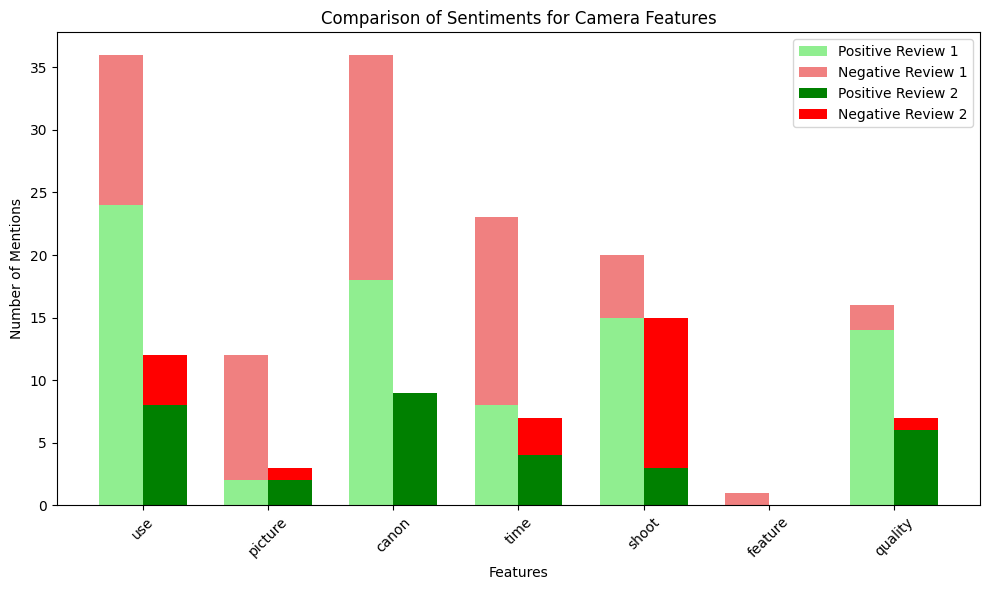

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_double_sentiment_comparison(dict1, dict2):
    # Assuming both dictionaries have the same structure and the same set of keys
    product = 'camera'  # if the product type needs to be dynamic, this should be adjusted
    features = list(dict1[product].keys())

    # Prepare data for plotting
    positives1 = [dict1[product][feature]['positive'] for feature in features]
    negatives1 = [dict1[product][feature]['negative'] for feature in features]
    positives2 = [dict2[product][feature]['positive'] for feature in features]
    negatives2 = [dict2[product][feature]['negative'] for feature in features]

    # Set up the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    index = np.arange(len(features))
    bar_width = 0.35

    # Create bars
    bars1_pos = ax.bar(index - bar_width/2, positives1, bar_width, label='Positive Review 1', color='lightgreen')
    bars1_neg = ax.bar(index - bar_width/2, negatives1, bar_width, label='Negative Review 1', color='lightcoral', bottom=positives1)
    
    bars2_pos = ax.bar(index + bar_width/2, positives2, bar_width, label='Positive Review 2', color='green')
    bars2_neg = ax.bar(index + bar_width/2, negatives2, bar_width, label='Negative Review 2', color='red', bottom=positives2)

    # Adding labels, title and axes ticks
    ax.set_xlabel('Features')
    ax.set_ylabel('Number of Mentions')
    ax.set_title('Comparison of Sentiments for Camera Features')
    ax.set_xticks(index)
    ax.set_xticklabels(features)
    ax.legend()

    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Call the function to plot the data
plot_double_sentiment_comparison(feature_table_1, feature_table_2)
